# L5d: Min Cost Max Flow as a Linear Programming Problem
In this lab, we will revisit the maximum flow (matching) problem and see how it can be formulated as a linear programming (LP) problem, with the objective of minimizing the cost of the flow. 

> **Learning objectives:**
>
> In this lab, students will learn to:
>
> * **Formulate flow problems as linear programs.** We translate a minimum cost maximum flow graph problem into a linear programming formulation with objective function, constraints, and bounds.
> * **Solve linear programming problems.** We use the GLPK solver through JuMP to solve the minimum cost maximum flow problem and extract optimal flow values.
> * **Analyze optimal flow solutions.** We visualize the optimal flow through the network and interpret how costs and capacities affect the solution.

This is a super useful problem formulation, as it can be used to solve a variety of practical problems, e.g., logistics, supply chain management, or operations and schedule optimization. Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [include command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, and more. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl"));

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl), check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types and data used in this material. 

### Constants
Let's define some constants that will be used throughout the notebook. See the comment for a description of each constant, what it represents, its value, units, and more.

In [2]:
# We are going to plot the path through a graph, so let's provide the coordinates for each node (the layout)
# This layout looks like our schematic but you can rearrange this if you want!
node_coordinates = [

    # source node (you)
    10.0 10.0 ; # 1 source node s (x,y) coordinates

    # people nodes (workers)
    11.0 11.0 ; # 2 people node (x,y) coordinates
    11.0 10.0 ; # 3 people node (x,y) coordinates
    11.0 9.0 ; # 4 people node (x,y) coordinates

    # job nodes (tasks)
    12.0 11.0 ; # 5 job node (x,y) coordinates
    12.0 10.0 ; # 6 job node (x,y) coordinates
    12.0 9.0 ; # 7 job node (x,y) coordinates
    12.0 8.0 ; # 8 job node (x,y) coordinates

    # sink nodes (targets, tasks done!)
    13.0 11.0 ; # 9 sink node t (x,y) coordinates
    13.0 10.0 ; # 10 sink node t (x,y) coordinates
    13.0 9.0 ; # 11 sink node t (x,y) coordinates
    13.0 8.0 ; # 12 sink node t (x,y) coordinates
    
    14.0 10.0 ; # 13 end node (x,y) coordinates
];

## Task 1: Build a task allocation graph model
Let's return to the task allocation problem, but with a twist. You're still node `1` (the source node, manager, etc.). We have a small bipartite graph setup: worker nodes connected to task nodes, where we need to allocate workers to tasks. In other words, we need to find a __flow__ through the network, and in particular we'll find the __maximum flow__.

> __Twist:__ We want every worker assigned to tasks such that we use all of our workers' capacity. However, we want the assignments to be made such that the overall cost of the assignments is minimized. In other words, we want to solve a __minimum cost maximum flow__ problem.

The problem graph edges are stored in `data/Workers-Tasks-MCMF-Bipartite.edgelist` with fields: 

> __Records__: Each record in our edgelist file has the comma-separated fields: `source,` `target,` `cost,` `lb capacity,` `ub capacity`. The `source` field is the id for the source node, for example `1`, the `target` field is the target node id, the `cost` is the cost of assigning the source node to the target node, the `lb capacity` is the lower bound capacity for the edge, and the `ub capacity` is the upper bound capacity for the edge.

In this activity, we'll focus on both the edge costs and the capacity constraints. Now let's set up our edge parser __callback function__:

In [3]:
"""
    function edgerecordparser(record::String, delim::Char=',') -> Tuple{Int, Int, Float64, Float64, Float64} | Nothing

This method is called to parse a single edge record from the edgelist file. It gets called once for each record in the file. 
The function splits the record into fields based on the specified delimiter and extracts the source node, target node, cost (weight), 
lower bound capacity, and upper bound capacity of the edge. It returns a tuple containing these values. If the record does not have 
the expected number of fields, it returns `nothing`.

### Arguments
- `record`: The edge record string to parse.
- `delim`: The delimiter used to split the record.

### Returns
- A tuple containing the source node, target node, cost, lower bound capacity, and upper bound capacity of the edge, or `nothing` if the record is invalid.
"""
function edgerecordparser(record::String, delim::Char=',')
    
    # record (five fields)
    # source, target, cost, lb, ub

    fields = split(record, delim) # this assumes a record of the form "source,target,cost,lb,ub"
    if length(fields) < 5 # we have 5 fields
        return nothing
    end

    # get my data from the line -
    source = parse(Int, fields[1]) # source id
    target = parse(Int, fields[2]) # target id
    cost = parse(Float64, fields[3]) # edge weight
    l = parse(Float64, fields[4]) # lower bound capacity
    u = parse(Float64, fields[5]) # upper bound capacity

    # return a tuple -
    return (source, target, cost, l, u)
end;

Next, let's set the path to the edge list file in the `path_to_edge_file::String` variable:

In [4]:
path_to_edge_file = joinpath(_PATH_TO_DATA, "Workers-Tasks-MCMF-Bipartite.edgelist"); # this points to the graph shown above

Next, construct a dictionary [of `MyConstrainedGraphEdgeModel` instances](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyConstrainedGraphEdgeModel) which stores the data for the edges. Let's save our edge models in the `myedgemodels::Dict{Int64, MyConstrainedGraphEdgeModel}` dictionary.

The keys in the edge dictionary will be the edge ids (which we can assume are unique), and the values will be the corresponding `MyConstrainedGraphEdgeModel` instances. Here, we've used the line index in the edgefile as the edge id.

In [5]:
myedgemodels = MyConstrainedGraphEdgeModels(path_to_edge_file, edgerecordparser, delim=',', comment='#')

Dict{Int64, MyConstrainedGraphEdgeModel} with 23 entries:
  5  => MyConstrainedGraphEdgeModel(5, 7, 11, 1.0, 0.0, 1.0)
  16 => MyConstrainedGraphEdgeModel(16, 3, 6, 1.0, 0.0, 1.0)
  20 => MyConstrainedGraphEdgeModel(20, 4, 6, 1.0, 0.0, 1.0)
  12 => MyConstrainedGraphEdgeModel(12, 2, 6, 1.0, 0.0, 1.0)
  8  => MyConstrainedGraphEdgeModel(8, 10, 13, 0.0, 0.0, 1.0)
  17 => MyConstrainedGraphEdgeModel(17, 3, 7, 1.0, 0.0, 1.0)
  1  => MyConstrainedGraphEdgeModel(1, 1, 3, 0.0, 0.0, 1.0)
  19 => MyConstrainedGraphEdgeModel(19, 4, 5, 1.0, 0.0, 1.0)
  0  => MyConstrainedGraphEdgeModel(0, 1, 2, 0.0, 0.0, 1.0)
  22 => MyConstrainedGraphEdgeModel(22, 4, 8, 1.0, 0.0, 1.0)
  6  => MyConstrainedGraphEdgeModel(6, 8, 12, 1.0, 0.0, 1.0)
  11 => MyConstrainedGraphEdgeModel(11, 2, 5, 1.0, 0.0, 1.0)
  9  => MyConstrainedGraphEdgeModel(9, 11, 13, 0.0, 0.0, 1.0)
  14 => MyConstrainedGraphEdgeModel(14, 2, 8, 1.0, 0.0, 1.0)
  3  => MyConstrainedGraphEdgeModel(3, 5, 9, 1.0, 0.0, 1.0)
  7  => MyConstrainedGraphEd

Finally, we can build a graph instance. Since this is a directed graph, we'll construct [a `MyDirectedBipartiteGraphModel` instance](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyDirectedBipartiteGraphModel) using [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/#VLDataScienceMachineLearningPackage.build). Let's save our graph model in the `directedgraphmodel::MyDirectedBipartiteGraphModel` variable.

In [6]:
myedgemodels[1] |> m-> typeof(m) |> T -> fieldnames(T)

(:id, :source, :target, :weight, :lower, :upper)

In [7]:
directedgraphmodel = let

    # initialize -
    s = 1; # what is the source node
    t = 13; # what is the sink node

    # call the build method to create the graph model
    model = build(MyDirectedBipartiteGraphModel, (
        s = s, # source index
        t = t, # sink index
        edges = myedgemodels
    ));

    
    model # return the model 
end;

In [8]:
directedgraphmodel.sink

13

The code block below shows how we visualized the flow network. 

The nodes in the graph are represented as circles, while the edges are represented as lines connecting these circles. Flow in this case goes from a source node ($s$, or node 1) to a sink node ($t$ or node 13). The numbers above the edges represent the __capacity__ of the edge (upper bound on the flow through the edge).

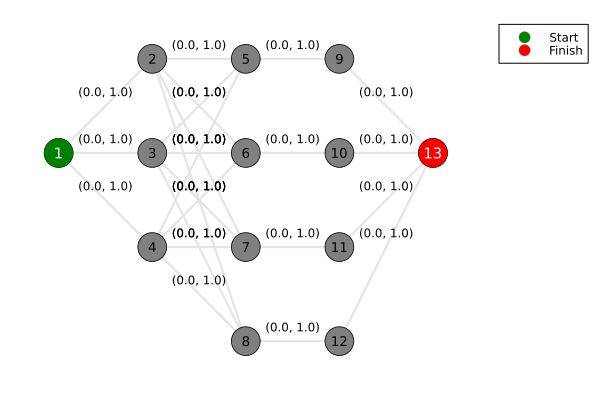

In [9]:
let

    # initialize -
    base_graphmodel = directedgraphmodel;
    source_node = 1; # this is where we start
    target_node = 13; # this is where we want to go

    # draw -
    q = plot();
    for (k,v) ∈ base_graphmodel.edgesinverse
       
        # now, get the source,target node index for this edge
        s = v[1];
        t = v[2];
        # draw baseline edge
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:gray90, lw=2, label="")
        
        # add weight annotation to edges -
        mx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
        my = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
        c = round.(base_graphmodel.capacity[(s,t)], digits=2) # changed to capacity from edges
        annotate!(mx, my + 0.15, text(string(c), 8, :black))
    end
    scatter!(node_coordinates[:,1], node_coordinates[:,2], axis=nothing, border=:none, label="", c=:gray, ms=16)
    
   
    scatter!([node_coordinates[source_node,1]], [node_coordinates[source_node,2]], 
             c=:green, ms=16, markerstroke=2, markerstrokecolor=:darkgreen, 
             label="Start")

    scatter!([node_coordinates[target_node,1]], [node_coordinates[target_node,2]], 
             c=:red, ms=16, markerstroke=2, markerstrokecolor=:darkred, 
             label="Finish")

    # number the nodes -
    n_nodes = size(node_coordinates, 1)
    for i in 1:n_nodes
        x = node_coordinates[i,1]
        y = node_coordinates[i,2]
        if i == source_node || i == target_node
            # white text for the red source node
            annotate!(x, y, text(string(i), 10, :white))
        else
            # black text for other nodes
            annotate!(x, y, text(string(i), 9, :black))
        end
    end

    # set the global plot attributes
    plot!(axis=nothing, border=:none, legend=:outertopright, legendfontsize=8, 
          background_color=:white, xlim=(9.5, 14.5), ylim=(7.5, 11.5))

    current() # show the current plot
end

## Task 2: Formulate the minimum cost maximum flow problem as a linear programming problem
In this task, we translate the data stored in our graph model into the components of our linear programming (LP) problem.  

We have a directed (bipartite) graph with nodes representing sources, sinks, and intermediate nodes representing a matching process. The edges represent the flow of goods or resources between these nodes. Each edge has a capacity (the maximum amount of flow that can pass through it) and a cost per unit of flow.

> __Formulation__: Let the directed graph be represented as $G = (\mathcal{V}, \mathcal{E})$, where $\mathcal{V}$ is the set of vertices (nodes) and $\mathcal{E}$ is the set of edges. Each edge $j \in \mathcal{E}$ has a capacity $c_j$ and a cost (weight) $w_j$ per unit of flow. Let $f_j$ be the flow on edge $j$, and let $s$ be the source node and $t$ be the sink node. The goal is to maximize the flow from the source to the sink while minimizing the total cost of the flow.

We use an incidence matrix formulation where $\mathbf{A} \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{E}|}$ represents the graph structure. For node $i$ and edge $j$:
- $A_{ij} = 1$ if edge $j$ is incoming to node $i$
- $A_{ij} = -1$ if edge $j$ is outgoing from node $i$  
- $A_{ij} = 0$ otherwise

Putting all this together, we can formulate the minimum cost maximum flow problem as the _primal_ linear program:
$$
\begin{align*}
\text{minimize} &\, \sum_{j \in \mathcal{E}} w_j f_j \\
\text{subject to} \quad \mathbf{A}\mathbf{f} &= \mathbf{b}\\
~0 \leq f_j &\leq c_j \quad\forall j \in \mathcal{E}
\end{align*}
$$
where $\mathbf{f} \in \mathbb{R}^{|\mathcal{E}|}$ is the vector of flows on each edge, and $\mathbf{b} \in \mathbb{R}^{|\mathcal{V}|}$ is the right-hand side vector with:
$$
b_i = \begin{cases}
-F & \text{if } i = s \text{ (source generates flow)} \\
F & \text{if } i = t \text{ (sink consumes flow)} \\
0 & \text{otherwise (flow conservation)}
\end{cases}
$$
where $F$ is the total flow from the source to the sink. The optimal solution to this problem (if it exists) will give the flow on each edge that minimizes the total cost while satisfying the flow conservation constraints and capacity constraints.

Let's start with the bounds.

In [10]:
directedgraphmodel.edgesinverse

Dict{Int64, Tuple{Int64, Int64}} with 23 entries:
  5  => (2, 6)
  16 => (5, 9)
  20 => (9, 13)
  12 => (4, 5)
  8  => (3, 5)
  17 => (6, 10)
  1  => (1, 2)
  19 => (8, 12)
  22 => (11, 13)
  23 => (12, 13)
  6  => (2, 7)
  11 => (3, 8)
  9  => (3, 6)
  14 => (4, 7)
  3  => (1, 4)
  7  => (2, 8)
  4  => (2, 5)
  13 => (4, 6)
  15 => (4, 8)
  ⋮  => ⋮

In [11]:
bounds = let

    # initialize -
    capacity = directedgraphmodel.capacity; # get the capacity
    number_of_edges = length(directedgraphmodel.edges); # how many edges do we have
    bounds = Array{Float64,2}(undef, number_of_edges, 2); # each row is an edge, col 1 is lb, col 2 is ub

    # TODO: loop over the edges and set the bounds
    for (k,v) ∈ directedgraphmodel.edgesinverse

        # get the edge index
        edge_index = k;
        lb = capacity[v][1];
        ub = capacity[v][2];

        # get nodes associated with this edge -
        s = v[1];
        t = v[2];

        # TODO: S2 We increase the flow into the network
        # TODO: If F ≥ workers with default (0,1) capacities, we need to increase the capacity of at least one node
        if (s == 1)
            ub = 2.0; # you are telling all the workers they can do up to two tasks, worker 3 can now do (0,2) on outward edges
        end

        # TODO: S2b We need worker 4 to do something
        if (s == 4 && t == 7)
            lb = 1.0; 
        end
        
        # TODO: S3. Worker 4 is on vacation. 
        # TODO: Uncomment the following lines to see what happens with S3
        # if (s == 4)
        #     ub = 0.0;
        # end

        # set the bounds
        bounds[edge_index, 1] = lb; # lower bound
        bounds[edge_index, 2] = ub; # upper bound
    end

    bounds # return;
end;

In [12]:
bounds

23×2 Matrix{Float64}:
 0.0  2.0
 0.0  2.0
 0.0  2.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 ⋮    
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0

Next, let's formulate the objective function coefficient vector. The objective function coefficients correspond to the costs associated with each edge in the graph. In our case, we want to minimize the total cost of the flow through the network.

We'll store the objective function coefficients in the `c::Vector{Float64}` vector.

In [13]:
directedgraphmodel.edges

Dict{Tuple{Int64, Int64}, Number} with 23 entries:
  (4, 5)   => 1.0
  (1, 2)   => 0.0
  (8, 12)  => 1.0
  (3, 7)   => 1.0
  (2, 5)   => 1.0
  (6, 10)  => 1.0
  (1, 3)   => 0.0
  (12, 13) => 0.0
  (4, 6)   => 1.0
  (5, 9)   => 1.0
  (1, 4)   => 0.0
  (2, 6)   => 1.0
  (3, 8)   => 1.0
  (11, 13) => 0.0
  (9, 13)  => 0.0
  (4, 7)   => 1.0
  (2, 7)   => 1.0
  (4, 8)   => 1.0
  (2, 8)   => 1.0
  ⋮        => ⋮

In [14]:
c = let

    # initalize -
    number_of_edges = length(directedgraphmodel.edges); # how many edges do we have
    weight_array = Array{Float64,1}(undef, number_of_edges); # each row is an edge
    weights = directedgraphmodel.edges;

    # main loop -
    for (k,v) ∈ directedgraphmodel.edgesinverse

        # get the edge index
        edge_index = k;
        wv = weights[v]; # weight value

        s = v[1]; # source node
        t = v[2]; # target node

        # TODO: S1: Let's modify some of the costs of operating an edges
        # TODO: Uncomment the following lines to see what happens when we modify the costs
        # if (s == 3 && t == 6)
        #     # Modify the weight for edge 3 -> 6
        #     wv = 10*wv; # example modification
        # end

        # set the weight
        weight_array[edge_index] = wv; # weight
    end

    
    weight_array # return
end;

In [15]:
c

23-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0

Now, let's formulate the right-hand side vector, which corresponds to the flow conservation constraints at each node in the graph. 

> __What's in the $\mathbf{b}$ vector?__ The right-hand side vector $\mathbf{b}\in\mathbb{R}^{|\mathcal{V}|}$ will have a value of `-F::Float64` at the source node, `F::Float64` at the sink node, and `0` at all other nodes. Why is that? The source node generates flow (negative value), the sink node consumes flow (positive value), and intermediate nodes conserve flow (zero net flow).

Let's save the right-hand side vector in the `b::Vector{Float64}` vector.

In [16]:
b = let

    # initialize -
    number_of_nodes = length(directedgraphmodel.nodes); # how many nodes do we have
    b = zeros(number_of_nodes); # each row is a node
    s = directedgraphmodel.source; # source node index
    t = directedgraphmodel.sink; # sink node index

    # TODO: S2 Change the amount of flow coming into the network
    # TODO: set the flow value
    F = 3.0; # flow value (to be sent from source to sink)

    # set the right-hand side values
    b[s] = -F; # source node
    b[t] = F; # sink node

    b; # return
end;

In [17]:
b

13-element Vector{Float64}:
 -3.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  3.0

Finally, let's formulate the constraint matrix $\mathbf{A}\in\mathbb{R}^{|\mathcal{V}|\times|\mathcal{E}|}$, which represents the flow conservation constraints at each node in the graph. 
> __What is in the constraint matrix $\mathbf{A}$?__ The constraint matrix will have a row for each node and a column for each edge. Using the incidence matrix convention: The entries in the matrix will be `1` if the edge is **incoming** to a node, `-1` if the edge is **outgoing** from a node, and `0` otherwise.

We'll store the constraint matrix in the `A::Array{Float64, 2}` variable.

In [18]:
A = let

    # initialize -
    number_of_nodes = length(directedgraphmodel.nodes); # how many nodes do we have
    number_of_edges = length(directedgraphmodel.edges); # how many edges do we have
    A = zeros(number_of_nodes, number_of_edges); # each row is a node, each col is an edge

    # main loop - fill in the constraint matrix
    for (k,v) ∈ directedgraphmodel.edgesinverse

        # get the edge index
        edge_index = k;

        # get the source and target nodes for this edge
        s = v[1];
        t = v[2];

        # set the entries in the constraint matrix
        A[s, edge_index] = -1.0; # outgoing edge from source node
        A[t, edge_index] = 1.0; # incoming edge to target node
    end

    A # return

end;

In [19]:
A

13×23 Matrix{Float64}:
 -1.0  -1.0  -1.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  1.0   0.0   0.0  -1.0  -1.0  -1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   1.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   1.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   1.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   1.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   1.0     -1.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0  -1.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0  -1.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0  -1.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0  …   1.0   0.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   1.0   0.0   0.0   0.0  -1.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   1.0   1.0   1.0   1.0

___

## Task 3: Setup and solve the linear programming problem
In this task, we will set up and solve the linear programming (LP) problem formulated using the components we computed in Task 2. 

First, we create an instance of [the `MyLinearProgrammingProblemModel` model](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyLinearProgrammingProblemModel) using [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/#VLDataScienceMachineLearningPackage.build) and store this model in the `primal_problem` variable. 
This model holds the data associated with the problem, e.g., the unit costs, the right-hand side vector, the constraint matrix (i.e., the flow conservation constraints), and the problem bounds.

In [20]:
primal_problem = build(MyLinearProgrammingProblemModel, (

    c = -c, # coefficients in the objective function (sum of the costs of operating an edge) # TODO: What is the "sense" of the problem by default?
    A = A, # flow conservation constraints
    b = b, # the net flow at each node

    # how much flow can we send on each edge?
    lb = bounds[:,1], # lower bound on flow on each edge
    ub = bounds[:,2] # upper bound on flow on each edge
));

Next, we pass the `primal_problem` variable to [the `solve(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/solvers/#VLDataScienceMachineLearningPackage.solve), which constructs the linear program using the [JuMP domain-specific language](https://jump.dev/). 

The implementation of [the `solve(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/solvers/#VLDataScienceMachineLearningPackage.solve) takes the data from the `primal_problem` instance, builds the various problem structures, and returns the solution in the `primal_solution` dictionary.

> __Why the try-catch block?__ The [solve(...) method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/solvers/#VLDataScienceMachineLearningPackage.solve) uses the [GLPK solver](https://en.wikipedia.org/wiki/GLPK) to solve the linear program. If the solver fails, the `solve(...)` method will throw an error. To prevent the notebook from crashing, we wrap the call to [the `solve(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/solvers/#VLDataScienceMachineLearningPackage.solve) in a `try-catch` block. If the solver fails, we catch the error and print a message to the user.

Solve the primal problem. The solution will be stored in the `primal_solution::Dict{String, Any}` dictionary.

In [21]:
primal_solution_dictionary = let

    # initialize -
    primal_solution = nothing;
    try
        primal_solution = solve(primal_problem) # call the solver
    catch error
        println(error)
    end
    
    primal_solution; # return
end;

What's in the solution dictionary?

In [22]:
primal_solution_dictionary

Dict{String, Any} with 3 entries:
  "argmax"          => [2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.…
  "status"          => OPTIMAL
  "objective_value" => -6.0

To visualize the solution, we can extract the flow values from the `primal_solution` dictionary and plot them on the original graph. The flow values represent the amount of flow on each edge in the graph.

In [23]:
flow = let

    # initialize -
    flow_dictionary = Dict{Tuple{Int,Int}, Float64}(); # key is (source,target), value is flow value
    primal_flow_vector = primal_solution_dictionary["argmax"]; # this is the flow vector from the primal solution

    for (k,v) ∈ directedgraphmodel.edgesinverse

        # get the edge index
        edge_index = k;

        # get the source and target nodes for this edge
        s = v[1];
        t = v[2];

        # get the flow value from the primal solution
        flow_value = primal_flow_vector[edge_index];

        # store in the dictionary
        flow_dictionary[(s,t)] = flow_value;
    end

    flow_dictionary; # return
end

Dict{Tuple{Int64, Int64}, Float64} with 23 entries:
  (4, 5)   => 0.0
  (1, 2)   => 2.0
  (6, 10)  => 1.0
  (8, 12)  => 0.0
  (12, 13) => 0.0
  (2, 5)   => 1.0
  (1, 3)   => 0.0
  (3, 7)   => 0.0
  (5, 9)   => 1.0
  (3, 8)   => 0.0
  (1, 4)   => 1.0
  (2, 6)   => 1.0
  (4, 6)   => 0.0
  (11, 13) => 1.0
  (9, 13)  => 1.0
  (4, 7)   => 1.0
  (2, 7)   => 0.0
  (4, 8)   => 0.0
  (2, 8)   => 0.0
  ⋮        => ⋮

Visualize the solution. The code block below shows how we visualized flow through the graph. The red lines represent the flow paths from the source to the sink, where the amount of flow through each edge is shown above the edge.

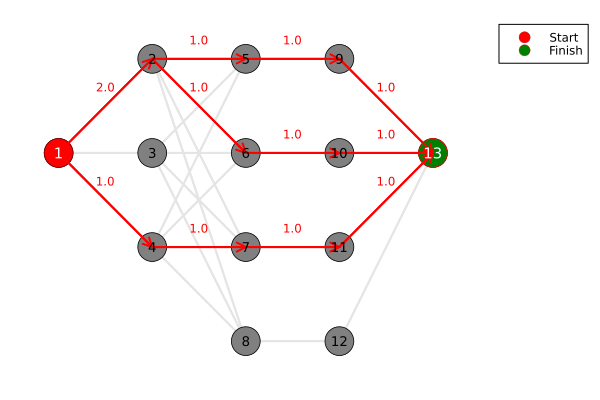

In [24]:
let

    # initialize -
    capacity = directedgraphmodel.capacity; # get the capacity dictionary
    flow_dictionary = flow;
    base_graphmodel = directedgraphmodel;
    source_node = 1; # this is where we start
    target_node = 13; # this is where we want to go
    path_edges = keys(flow); # this is a dictionary of (u,v) → flow_value
 
    # draw -
    q = plot();
    for (k,v) ∈ base_graphmodel.edgesinverse
       
        # now, get the source,target node index for this edge
        s = v[1];
        t = v[2];
        
        # draw baseline edge
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:gray90, lw=2, label="")
    end
    scatter!(node_coordinates[:,1], node_coordinates[:,2], axis=nothing, border=:none, label="", c=:gray, ms=16)
    
   
    scatter!([node_coordinates[source_node,1]], [node_coordinates[source_node,2]], 
             c=:red, ms=16, markerstroke=2, markerstrokecolor=:darkred, 
             label="Start")

    scatter!([node_coordinates[target_node,1]], [node_coordinates[target_node,2]], 
             c=:green, ms=16, markerstroke=2, markerstrokecolor=:red, 
             label="Finish")

    # plot the flow path -
    for ((s,t),flow_value) ∈ flow_dictionary

        if flow_value == 0.0
            continue # skip zero flow edges
        end
       
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:red, lw=2, label="")
        
        # annotate the path-edge weight in red slightly above the red edge
        mwx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
        mwy = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
        w = round(flow_dictionary[(s,t)], digits=2)
        annotate!(mwx, mwy + 0.20, text(string(w), 8, :red))
    end

    # number the nodes -
    n_nodes = size(node_coordinates, 1)
    for i in 1:n_nodes
        x = node_coordinates[i,1]
        y = node_coordinates[i,2]
        if i == source_node || i == target_node
            # white text for the red source node
            annotate!(x, y, text(string(i), 10, :white))
        else
            # black text for other nodes
            annotate!(x, y, text(string(i), 9, :black))
        end
    end

    # set the global plot attributes
    plot!(axis=nothing, border=:none, legend=:outertopright, legendfontsize=8, 
          background_color=:white, xlim=(9.5, 14.5), ylim=(7.5, 11.5))

    current() # show the current plot
end

Wow! That is super cool. We solved a minimum cost maximum flow problem using linear programming! Let's play around with the edge costs and capacities to see how they affect the optimal flow solution.

### Scenarios
1. Suppose the cost of assigning worker 3 to task 6 increases significantly. How does this change the optimal flow? Does the algorithm find a new path that avoids this expensive assignment? There is a fun hidden wrinkle here. 
2. Suppose we increase the amount of flow we push into the network (i.e., increase the `F` parameter). How does this affect the optimal flow and the total cost? Does the algorithm find new paths to accommodate the increased flow?
3. Worker 4 is going on vacation and cannot be assigned to any tasks. How does this affect the optimal flow and the total cost? Can the algorithm still find a feasible solution? There are a couple of ways to handle this. One way is to set the upper bound capacity of all edges connected to worker 4 to `0`. Another way is to remove worker 4 from the graph entirely. Alternatively, we can set the capacity of edge (1,4) to zero. Let's see how the algorithm handles these changes.

___

## Summary
In this lab, we explored how to formulate and solve minimum cost maximum flow problems using linear programming. We translated a graph-based optimization problem into a mathematical programming formulation and solved it using the GLPK solver through JuMP.

> **Key takeaways:**
> * **Linear programming formulates flow problems.** We converted a minimum cost maximum flow graph problem into a linear program with objective function (minimize total cost), constraints (flow conservation), and bounds (edge capacities).
> * **Matrix formulation captures graph structure.** We built the constraint matrix A to represent flow conservation at each node, with entries of -1 for outgoing edges, +1 for incoming edges, and 0 otherwise.
> * **Optimal solutions minimize cost while satisfying constraints.** The GLPK solver found the flow assignment that minimizes total cost while respecting capacity limits and ensuring flow conservation at all nodes.

__Where do we go from here?__ The minimum cost maximum flow problem is a fundamental optimization problem with many real-world applications. We can extend this formulation to more complex scenarios like multi-commodity flows, time-varying capacities, or stochastic demands. 

In lecture L6a we will look at the dual problem associated with this primal problem and see how it can be interpreted in the context of the original graph problem. Going to be fun!
___